# Household-Energy ABM: Notebook Tutorial


<span id="doc-what"></span>

**What this notebook demonstrates**  
This tutorial shows how to run our climate-linked, geospatial household‑energy ABM on a small geographic subset (ward/LSOA) *inside Jupyter*, generate hourly/daily/annual outputs and visuals, and compare ABM totals to DESNZ (electricity + gas) at LSOA level. The same core model underpins the headless CLI and the Solara dashboard.



## Inputs & prerequisites
<span id="doc-inputs"></span>

**Data you need locally**
- **Neighbourhood GeoJSON** of dwellings with at least: `UPRN` (or `fid`/`id`), `property_type`, and geometry.
- **Hourly climate parquet** with columns: `timestamp` (UTC), `latitude`, `longitude`, `temp_C` (rectangular T×P grid).
- **DESNZ LSOA workbooks** (electricity + gas, 2010–2023) for validation.

**Repository layout (high‑level):**

```
household_energy/            # Python package (entry points)
├── agent.py                 # HouseholdAgent & PersonAgent
├── model.py                 # EnergyModel core
├── climate.py               # ClimateField helpers
├── run.py                   # Headless run (CLI)
├── analyze.py               # Post‑run plots & maps
└── server.py                # Live dashboard

notebooks/
├── 01-climate-prep.ipynb    # Prepare hourly climate parquet
└── 02-energy-model-tests.ipynb  # Validation vs DESNZ (2020–2023)

data/                        # 🔒 Git‑ignored sensitive inputs
results/                     # Model outputs (git‑ignored)
```


**System requirements**

* **Python:** 3.10 or newer.
* **OS:** Linux/macOS/Windows.
* **RAM:** 8–16 GB recommended for neighbourhood‑scale runs; increase for city‑wide.
* **Disk:** Allow several GB for multi‑year hourly outputs.

---

**Installation**

Create an isolated environment and install dependencies:

```bash
python -m venv esa_mesa
source esa_mesa/bin/activate   # Windows: esa_mesa\Scripts\activate
pip install -r requirements.txt
pip install -e .
```

Once the installation is completed in the command line you can experiment with the different tools below. 

In [ ]:
#!git clone https://github.com/AlejandroBeltranA/spdt_abm.git
#%cd spdt_abm
#!pip install -e .


In [6]:
import sys, os, importlib, pathlib, json, subprocess, shlex
from datetime import datetime
print(sys.version)
try:
    import household_energy
    print("household_energy package is importable ✅")
except Exception as e:
    print("household_energy not importable yet. If needed, run:")
    print("!pip install -e .")
    raise


3.12.1 (v3.12.1:2305ca5144, Dec  7 2023, 17:23:38) [Clang 13.0.0 (clang-1300.0.29.30)]
household_energy package is importable ✅


## Model summary
<span id="doc-model"></span>

Each **HouseholdAgent** starts from a cached **hourly base load** (derived from calibrated annual kWh and scaled by property type, SAP, floor area, envelope, heating/fuel, and simple policy levers). **PersonAgents** add occupancy‑dependent spikes. Each hour the model samples the nearest climate grid point per dwelling; **heating/cooling** add kWh via linear degree‑based slopes around setpoints, damped when nobody is home. Model‑level reporters include `total_energy`, per‑type splits, wealth splits, and `ambient_mean_tempC`.


## Key objects & expected columns
<span id="doc-objects"></span>

Set up the path to our data and generate a few visualizations to confirm their shape and coverage. 

In [9]:
from pathlib import Path

#  --- data paths ---
GEOJSON = Path('../data/epc_abm_newcastle.geojson')
CLIMATE = Path('../data/ncc_2t_timeseries_2010_2039.parquet')
OUTDIR_QUICK = Path('results_quick')
OUTDIR_WIN   = Path('results_2020_2024')

for p in [GEOJSON, CLIMATE]:
    print(p, "exists:", p.exists())


../data/epc_abm_newcastle.geojson exists: True
../data/ncc_2t_timeseries_2010_2039.parquet exists: True


**Climate parquet schema**  
`timestamp` (UTC), `latitude`, `longitude`, `temp_C`; recommended **rectangular T×P** grid.

[Climate parquet check]
  File: ../data/ncc_2t_timeseries_2010_2039.parquet
  Rows: 3,506,400 | T: 175,320 | P: 20 | T×P: 3,506,400
  Duplicates dropped: 9120
  Rows per timestamp → min/median/max: 20/20/20
  ✅ Rectangular grid (full T×P).


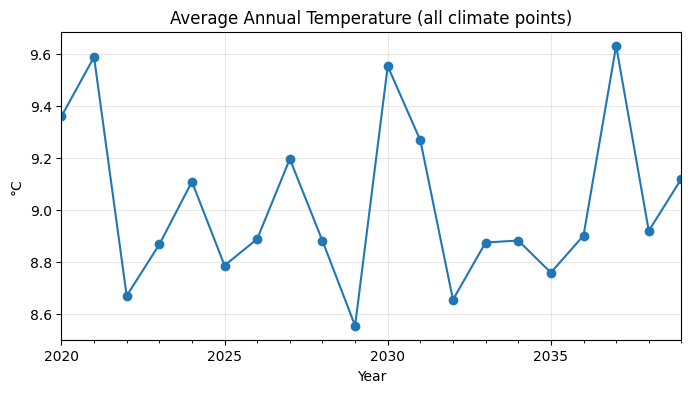

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
from household_energy.climate import ClimateField

# --- 1. Load and validate ---
ClimateField.validate_parquet(CLIMATE, verbose=True)

cf = ClimateField(CLIMATE)

# --- 2. Build dataframe: average across all points ---
temps_mean = cf.temps.mean(axis=1)  # average across P points
df = pd.DataFrame({
    "time": pd.to_datetime(cf.times),
    "temp_C": temps_mean,
}).set_index("time")

# --- 3. Resample to annual averages ---
annual = df["temp_C"].resample("YE").mean()

# --- 4. Plot ---
plt.figure(figsize=(8,4))
annual.plot(marker="o")
plt.title("Average Annual Temperature (all climate points)")
plt.ylabel("°C")
plt.xlabel("Year")
plt.grid(True, alpha=0.3)
plt.show()


The above plot shows the average annual temperature for our Newcastle polygon across the ClimateDT projections. 

Next, we'll look at our geographic coverage of these points above our polygon of interest. 

In [3]:
import pandas as pd
from household_energy.climate import ClimateField
import plotly.express as px
# --- load and slice one summer day ---

times = pd.to_datetime(cf.times)
day = "2022-07-15"  # 🔧 pick your summer day
mask = (times >= pd.to_datetime(day)) & (times < pd.to_datetime(day) + pd.Timedelta(days=1))

# take daily mean temp per point
daily_mean = cf.temps[mask, :].mean(axis=0)

# build dataframe for plotly
df = pd.DataFrame({
    "latitude": cf.points[:,0],
    "longitude": cf.points[:,1],
    "temp_C": daily_mean
})

# --- interactive scatter map ---
fig = px.scatter_map(
    df,
    lat="latitude",
    lon="longitude",
    color="temp_C",
    color_continuous_scale="RdYlBu_r",
    opacity=0.8,
    zoom=10,
    height=600,
    map_style="carto-positron",  # Maplibre basemap
    title=f"Newcastle 2m Temperature — {day}",
    labels={"temp_C": "2m Temp (°C)"}
)
fig.update_layout(margin={"r": 0, "t": 40, "l": 0, "b": 0})
fig.show()


Now we use the `household_energy.climat` module to map each home to a climate data point. The `map_households` function generates a spatial grid of climate points and then matches each household to the nearest point then assigns that temperature for that particular time period. 

Below is a visualization of how the coverage of temperature across homes varies. 

In [4]:
import numpy as np
import pandas as pd
import geopandas as gpd
import plotly.express as px
from household_energy.climate import ClimateField  # uses map_households:contentReference[oaicite:0]{index=0}

DAY = "2022-07-15"  # UTC


# 1) Climate daily mean temps
cf = ClimateField(CLIMATE)
times = pd.to_datetime(cf.times)
mask = (times >= pd.to_datetime(DAY)) & (times < pd.to_datetime(DAY) + pd.Timedelta(days=1))
daily_mean = cf.temps[mask, :].mean(axis=0)

# 2) Households lat/lon
gdf = gpd.read_file(GEOJSON).to_crs(4326)
geom = gdf.geometry
pts = geom.centroid if (geom.geom_type != "Point").any() else geom
lats, lons = pts.y.to_numpy(), pts.x.to_numpy()

# 3) Map households to climate grid
idx = cf.map_households(lats, lons)
temps_matched = daily_mean[idx]

df_hh = pd.DataFrame({"lat": lats, "lon": lons, "temp_C": temps_matched})

# 4) Plotly Maplibre scatter
fig = px.scatter_map(
    df_hh,
    lat="lat",
    lon="lon",
    color="temp_C",
    color_continuous_scale="RdYlBu_r",
    opacity=0.8,
    zoom=10,
    height=600,
    map_style="carto-positron",  # Maplibre style
    title=f"Household Coverage • Matched 2m Temp — {DAY}",
    labels={"temp_C": "2m Temp (°C)"}
)
fig.update_layout(margin={"r":0,"t":40,"l":0,"b":0})
fig.show()

In [5]:
# tidy up unused objects

import gc
gc.collect()

579

### Validate GeoJSON

In [6]:
import geopandas as gpd

# --- load households ---
gdf = gpd.read_file(GEOJSON)

# Ensure WGS84
if gdf.crs is None:
    print("⚠️ No CRS found, setting to EPSG:4326 (assumed).")
    gdf = gdf.set_crs(4326)
else:
    gdf = gdf.to_crs(4326)

# Fields used in the model
fields = [
    #"UPRN","uprn","fid",    # IDs
    "property_type","sap_rating","energy_cal_kwh","energy_demand_kwh",
    "floor_area_m2","property_age","main_fuel_type","main_heating_system",
    "retrofit_envelope_score","imd_decile",
    "heating_controls","meter_type",
    "cwi_flag","swi_flag","loft_ins_flag","floor_ins_flag","glazing_flag",
    "is_electric_heating","is_gas","is_oil","is_solid_fuel","is_off_gas"
]

present = [c for c in fields if c in gdf.columns]
missing = [c for c in fields if c not in gdf.columns]
print("✅ Found columns:", present)
print("❌ Missing columns:", missing)

# Descriptive stats
desc = {}
for c in present:
    if gdf[c].dtype.kind in "biufc":  # numeric
        desc[c] = gdf[c].describe().to_dict()
    else:  # categorical
        desc[c] = gdf[c].value_counts(dropna=False).head(10).to_dict()

import json
print(json.dumps(desc, indent=2))


✅ Found columns: ['property_type', 'sap_rating', 'energy_cal_kwh', 'energy_demand_kwh', 'floor_area_m2', 'property_age', 'main_fuel_type', 'main_heating_system', 'retrofit_envelope_score', 'heating_controls', 'meter_type', 'cwi_flag', 'swi_flag', 'loft_ins_flag', 'floor_ins_flag', 'glazing_flag', 'is_electric_heating', 'is_gas', 'is_oil', 'is_solid_fuel', 'is_off_gas']
❌ Missing columns: ['imd_decile']
{
  "property_type": {
    "small block of flats/dwelling converted in to flats": 48922,
    "semi-detached house": 29940,
    "mid-terraced house": 23965,
    "large block of flats": 16669,
    "end-terraced house": 11394,
    "detached house": 10389,
    "block of flats": 84
  },
  "sap_rating": {
    "count": 141363.0,
    "mean": 66.43568684875109,
    "std": 11.801666227792612,
    "min": 1.0,
    "25%": 60.0,
    "50%": 68.0,
    "75%": 74.0,
    "max": 117.0
  },
  "energy_cal_kwh": {
    "count": 141363.0,
    "mean": 12972.078259913253,
    "std": 9252.559394401016,
    "min": -

Next we'll plot a sample of the data over the Newcastle area so we can visually inspect the components. 

In [9]:
import numpy as np
import pandas as pd
import geopandas as gpd
import folium
from folium.plugins import MarkerCluster
import branca.colormap as cm

# --- load & prep ---
gpts = gdf.dropna(subset=["geometry"]).copy()
gpts = gpts.to_crs(4326) if gpts.crs else gpts.set_crs(4326)
if (gpts.geometry.geom_type != "Point").any():
    gpts["geometry"] = gpts.geometry.centroid

# Color scale from calibrated kWh (p5–p95 caps)
ene = pd.to_numeric(gpts["energy_cal_kwh"], errors="coerce")
if np.isfinite(ene).any():
    vmin, vmax = np.nanpercentile(ene, [5, 95])
else:
    vmin, vmax = 0.0, 1.0
cmap = cm.linear.YlOrRd_09.scale(vmin, vmax).to_step(10)
cmap.caption = "Calibrated annual energy (kWh)"

def color_for(val):
    if pd.isna(val):
        return "#bdbdbd"
    return cmap(min(max(float(val), vmin), vmax))

# Map scaffold
centre = [gpts.geometry.y.mean(), gpts.geometry.x.mean()]
m = folium.Map(location=centre, zoom_start=12, tiles="CartoDB positron")

title_html = """
<div style="position: fixed; top: 10px; left: 50px; z-index: 9999;
     background: rgba(255,255,255,.9); padding: 6px 10px; border-radius: 6px;
     font-family: system-ui, -apple-system, Segoe UI, Roboto, sans-serif; font-size: 14px;">
  <b>Household Energy — Calibrated kWh/year</b>
</div>"""
m.get_root().html.add_child(folium.Element(title_html))

# --- (A) Pseudo-heatmap: many small, translucent dots  ---
MAX_ALL = 60000  # adjust based on browser perf 
base = gpts if len(gpts) <= MAX_ALL else gpts.sample(MAX_ALL, random_state=0)
layer_all = folium.FeatureGroup(name=f"All households (n={len(base):,})", show=True)
for r in base.itertuples():
    val = getattr(r, "energy_cal_kwh", np.nan)
    col = color_for(val)
    folium.CircleMarker(
        location=[r.geometry.y, r.geometry.x],
        radius=2,                # tiny dot
        color=col, weight=0,     # no stroke
        fill=True, fill_color=col, fill_opacity=0.35,  # translucent
    ).add_to(layer_all)
layer_all.add_to(m)

# --- (B) Sampled popups layer (storytelling) ---
SAMPLE_N = min(len(gpts), 5000)  # tweak as you like
sample = gpts.sample(SAMPLE_N, random_state=42)
cluster = MarkerCluster(name=f"Sampled homes (n={len(sample):,})", show=False).add_to(m)

def fmt(x, d=0):
    try:
        return f"{float(x):,.{d}f}"
    except Exception:
        return "—"

for r in sample.itertuples():
    val = getattr(r, "energy_cal_kwh", np.nan)
    col = color_for(val)
    popup = folium.Popup(f"""
        <div style="font-family:system-ui, sans-serif; font-size:12px; line-height:1.25;">
          <b>UPRN:</b> {getattr(r,'UPRN','—')}<br/>
          <b>Type:</b> {getattr(r,'property_type','—')} | <b>Age:</b> {getattr(r,'property_age','—')}<br/>
          <b>Fuel:</b> {getattr(r,'main_fuel_type','—')} | <b>System:</b> {getattr(r,'main_heating_system','—')}<br/>
          <b>Energy:</b> {fmt(val,0)} kWh/yr
        </div>
    """, max_width=320)
    folium.CircleMarker(
        location=[r.geometry.y, r.geometry.x],
        radius=3, color=col, weight=0.5, opacity=0.9,
        fill=True, fill_color=col, fill_opacity=0.85,
        popup=popup,
        tooltip=f"{fmt(val,0)} kWh/yr" if pd.notna(val) else None,
    ).add_to(cluster)

# Legend + layers
cmap.add_to(m)

# --- (C) Add annual temperature layer ---
YEAR = 2022                   

cf = ClimateField(CLIMATE)
times = pd.to_datetime(cf.times, utc=True)

# slice calendar year in UTC
start = pd.Timestamp(f"{YEAR}-01-01", tz="UTC")
end   = pd.Timestamp(f"{YEAR+1}-01-01", tz="UTC")
mask  = (times >= start) & (times < end)
assert mask.any(), f"No climate rows in {YEAR}. Range: {times.min()} → {times.max()}"

# Annual mean temperature per climate point (shape [P])
ann_meanP = cf.temps[mask, :].mean(axis=0)

# Map ONLY the sampled households to nearest climate point
s_lats = sample.geometry.y.to_numpy(np.float32)
s_lons = sample.geometry.x.to_numpy(np.float32)
s_idx  = cf.map_households(s_lats, s_lons)
s_temp = ann_meanP[s_idx]  # per-sampled-household annual mean °C

# Temp color scale from the sample distribution
tmin, tmax = (np.nanpercentile(s_temp, [5, 95])
              if np.isfinite(s_temp).any() else (0.0, 1.0))
tmap = cm.LinearColormap(
    colors=list(reversed(cm.linear.RdYlBu_11.colors)),
    vmin=float(tmin),
    vmax=float(tmax),
)
tmap.caption = f"Annual mean 2m temp (°C) • {YEAR}"

# Render: small, translucent dots (same look), optional pane so temp sits under energy
layer_hh = folium.FeatureGroup(name=f"Sampled • annual mean temp {YEAR} (n={len(sample):,})", show=False)
for (y, x, t) in zip(s_lats, s_lons, s_temp):
    if not np.isfinite(t):
        continue
    col = tmap(min(max(float(t), tmin), tmax))
    folium.CircleMarker(
        [y, x],
        radius=2,
        color=col, weight=0,
        fill=True, fill_color=col, fill_opacity=0.22,  # extra translucent so energy still pops
        tooltip=f"{t:.2f} °C",
    ).add_to(layer_hh)
layer_hh.add_to(m)

tmap.add_to(m)
 
folium.LayerControl(collapsed=False).add_to(m)



In [10]:
from IPython.display import IFrame

m.save("household_energy_map.html")


In [10]:
out = Path("household_energy_map.html").resolve()
print("Open in browser:", out.as_uri())


Open in browser: file:///Users/abeltran/Documents/GitHub/spdt_abm/notebooks/household_energy_map.html


**EnergyModel(...)**  
- Required: `gdf` (GeoDataFrame of dwellings). Optional: `climate_parquet`, `climate_start` (UTC), `local_tz`, `collect_agent_level`, `agent_collect_every`.

In [11]:
from household_energy.model import EnergyModel
from household_energy.climate import ClimateField
import pandas as pd
import geopandas as gpd
gdf = gpd.read_file(GEOJSON)

Below we print a list of Wards for us to select from.

In [12]:
# Inspect columns first to confirm the right field
print(gdf.columns)

# Then list unique ward names
wards = gdf["ward_code"].dropna().unique()
print(f"Found {len(wards)} wards:")
for w in sorted(wards):
    print(" •", w)


Index(['UPRN', 'lsoa_code', 'local_authority', 'ward_code', 'habitable_rooms',
       'sap_rating', 'floor_area_m2', 'property_type', 'property_age',
       'main_fuel_type', 'main_heating_system', 'sap_band_ord',
       'retrofit_envelope_score', 'is_off_gas', 'energy_demand_kwh', 'factor',
       'energy_cal_kwh', 'is_heatpump_candidate', 'heatpump_candidate_class',
       'heating_controls', 'meter_type', 'cwi_flag', 'swi_flag',
       'loft_ins_flag', 'floor_ins_flag', 'glazing_flag',
       'is_electric_heating', 'is_gas', 'is_oil', 'is_solid_fuel',
       'epc_lodgement_date_year', 'geometry'],
      dtype='object')
Found 41 wards:
 • E05001068
 • E05001069
 • E05001074
 • E05001076
 • E05001081
 • E05001082
 • E05001143
 • E05011436
 • E05011437
 • E05011438
 • E05011439
 • E05011440
 • E05011441
 • E05011442
 • E05011443
 • E05011444
 • E05011445
 • E05011446
 • E05011447
 • E05011448
 • E05011449
 • E05011450
 • E05011451
 • E05011452
 • E05011453
 • E05011454
 • E05011455
 • 

In [13]:
ward_name = wards[2] # 🔧 pick your ward by name/code
gdf_small = gdf[gdf["ward_code"] == ward_name].copy()
gdf_small = (gdf_small.sort_values("epc_lodgement_date_year", ascending=False)
                     .drop_duplicates(subset="UPRN", keep="first"))
print(f"{len(gdf_small)} dwellings in {ward_name}")

4093 dwellings in E05011456


In [14]:
clim_path = CLIMATE  
cf = ClimateField(clim_path)
start_utc = pd.to_datetime(cf.times[0], utc=True)  # begin at climate start
print(start_utc)

m = EnergyModel(
    gdf=gdf_small,
    climate_parquet=clim_path,
    climate_start=start_utc,
    local_tz="Europe/London",
    collect_agent_level=True,   # keep per-household traces
    agent_collect_every=24      # once per day
)


2020-01-01 00:00:00+00:00


/Users/abeltran/Documents/GitHub/spdt_abm/household_energy/model.py:191: RuntimeWarning: Mean of empty slice
  np.nanmean([getattr(h, "ambient_tempC", np.nan) for h in m.household_agents])


In [15]:
for h in range(24*7):   # e.g. 3 days
    m.step()

df_model = m.model_dc.get_model_vars_dataframe()
df_agent = m.agent_dc.get_agent_vars_dataframe()

print(df_model.head())
print(df_agent.head())


   mid-terraced house  semi-detached house  \
0            0.000000             0.000000   
1         2551.005590          7633.329282   
2         2545.604803          7617.215573   
3         2538.288549          7595.468942   
4         2566.445654          7680.907541   

   small block of flats/dwelling converted in to flats  large block of flats  \
0                                           0.000000                0.000000   
1                                        5092.800055             1370.394532   
2                                        5078.591425             1366.405775   
3                                        5059.435810             1360.980836   
4                                        5135.121284             1381.401442   

   block of flats  end-terraced house  detached house  \
0             0.0            0.000000        0.000000   
1             0.0         1616.172572     9285.409120   
2             0.0         1612.680976     9272.882017   
3             

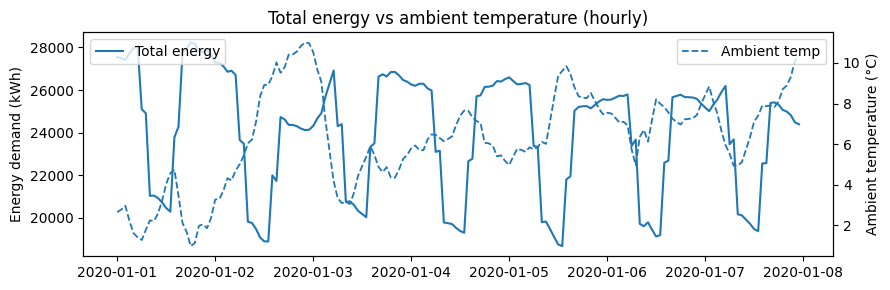

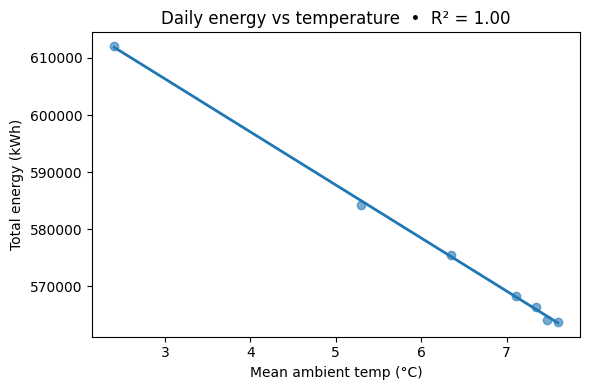

/var/folders/rz/68rzz4790djdsk13ycd911f00000gr/T/ipykernel_14235/2124406241.py:101: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout(); plt.show()


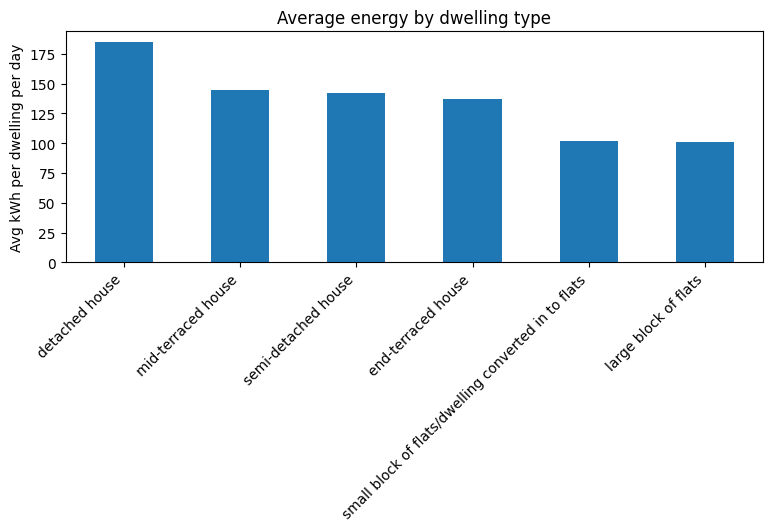

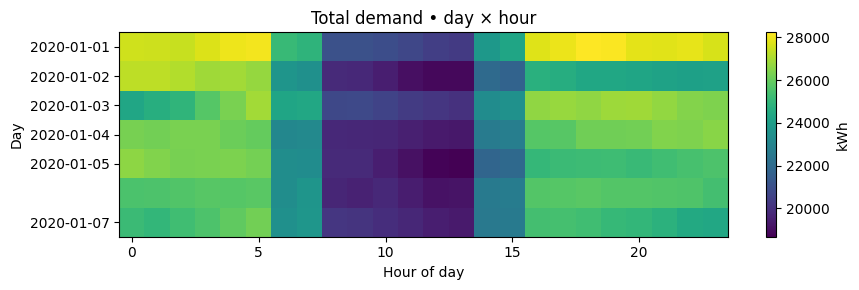

In [ ]:
# ===== Robust visuals: hourly + daily + by-type + day×hour =====
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from collections import Counter

def model_df_with_time(m):
    """Model-level df with proper UTC hourly DateTimeIndex, t=0 dropped."""
    df = m.datacollector.get_model_vars_dataframe().copy()   # model collects every step
    df = df.iloc[1:].copy()  # drop t=0 init snapshot (pre-first-step)  ✅
    if getattr(m, "climate", None) is not None:
        start_utc = pd.to_datetime(m.climate.times[getattr(m, "_t0", 0)], utc=True)
        df.index = start_utc + pd.to_timedelta(np.arange(len(df)), unit="h")
        df.index.name = "hour_start_utc"
    return df

def agent_household_df(m):
    if getattr(m, "agent_dc", None) is None:
        return None
    try:
        df = m.agent_dc.get_agent_vars_dataframe()
    except Exception:
        return None
    if isinstance(df.index, pd.MultiIndex):
        df = df.reset_index()
    if "agent_type" in df.columns:
        df = df[df["agent_type"] == "household"].copy()
    return df

# --- pull data ---
model_df = model_df_with_time(m)
agent_df = agent_household_df(m)

# 1) Hourly: Total energy vs ambient temperature
fig, ax1 = plt.subplots(figsize=(9,3))
ax1.plot(model_df.index, model_df["total_energy"].astype(float), lw=1.5, label="Total energy")
ax1.set_ylabel("Energy demand (kWh)")
ax1.set_xlabel("")
ax1.set_title("Total energy vs ambient temperature (hourly)")
ax2 = ax1.twinx()
if "ambient_mean_tempC" in model_df.columns:
    ax2.plot(model_df.index, pd.to_numeric(model_df["ambient_mean_tempC"], errors="coerce"),
             "--", lw=1.3, label="Ambient temp")
    ax2.set_ylabel("Ambient temperature (°C)")
ax1.legend(loc="upper left"); ax2.legend(loc="upper right")
fig.tight_layout()
plt.show()

# 2) Daily aggregates: bars (kWh) + temp line
# Build daily table (sum kWh, mean temp)
temp_col = "ambient_mean_tempC" if "ambient_mean_tempC" in model_df.columns else (
           "ambient_mean_tempC_avg" if "ambient_mean_tempC_avg" in model_df.columns else None)

agg_dict = {"total_energy": "sum"}
if temp_col: agg_dict[temp_col] = "mean"

daily = model_df.resample("D").agg(agg_dict).copy()
if temp_col:
    daily.rename(columns={temp_col: "ambient_mean_tempC"}, inplace=True)

# Drop rows with missing values
daily = daily.replace([np.inf, -np.inf], np.nan).dropna(subset=["total_energy", "ambient_mean_tempC"])

# If not enough data, skip gracefully
if len(daily) >= 2 and daily["ambient_mean_tempC"].nunique() > 1:
    x = daily["ambient_mean_tempC"].to_numpy(dtype=float)
    y = daily["total_energy"].to_numpy(dtype=float)

    # Robust linear fit
    coef = np.polyfit(x, y, 1)
    xg = np.linspace(np.nanmin(x), np.nanmax(x), 100)
    yg = np.polyval(coef, xg)
    r  = np.corrcoef(x, y)[0, 1]
    r2 = float(r*r)

    fig, ax = plt.subplots(figsize=(6,4))
    ax.scatter(x, y, alpha=0.6)
    ax.plot(xg, yg, lw=2)
    ax.set_xlabel("Mean ambient temp (°C)")
    ax.set_ylabel("Total energy (kWh)")
    ax.set_title(f"Daily energy vs temperature  •  R² = {r2:.2f}")
    fig.tight_layout(); plt.show()
else:
    print("ℹ️ Not enough daily data (or no temperature column) to plot temp–energy scatter.")


# 3) By dwelling type (period avg per dwelling per day)
prop_cols = [c for c in model_df.columns if hasattr(m, "energy_by_type") and c in m.energy_by_type.keys()]
if prop_cols:
    totals_by_type = model_df[prop_cols].sum(numeric_only=True)
    type_counts = Counter((getattr(h, "property_type", "") or "").strip().lower() for h in m.household_agents)
    counts = pd.Series({k: type_counts.get(k, 0) for k in totals_by_type.index})
    valid = counts > 0
    totals_by_type, counts = totals_by_type[valid], counts[valid]
    days = max(1.0, len(model_df) / 24.0)
    avg_per_dwelling_per_day = (totals_by_type / counts) / days
    fig, ax = plt.subplots(figsize=(9,3))
    avg_per_dwelling_per_day.sort_values(ascending=False).plot(kind="bar", ax=ax)
    ax.set_ylabel("Avg kWh per dwelling per day")
    ax.set_title("Average energy by dwelling type")
    ax.set_xlabel(""); plt.xticks(rotation=45, ha="right")
    fig.tight_layout(); plt.show()
else:
    print("ℹ️ No property-type columns found in model_df; skipping by-type chart.")

# 4) Day × Hour heatmap (hourly demand structure)
if isinstance(model_df.index, pd.DatetimeIndex):
    pivot = model_df.pivot_table(
        index=model_df.index.normalize(),
        columns=model_df.index.hour,
        values="total_energy",
        aggfunc="sum",
    ).fillna(0.0)
    fig = plt.figure(figsize=(9,3))
    im = plt.imshow(pivot.values, aspect="auto")
    plt.colorbar(im, label="kWh")
    plt.xlabel("Hour of day"); plt.ylabel("Day")
    plt.title("Total demand • day × hour")
    yticks = np.linspace(0, len(pivot.index)-1, min(len(pivot.index), 6)).astype(int)
    plt.yticks(yticks, [d.strftime("%Y-%m-%d") for d in pivot.index[yticks]])
    fig.tight_layout(); plt.show()
else:
    print("ℹ️ model_df does not have a DateTimeIndex; skipping day×hour heatmap.")


In [17]:
print(daily[["ambient_mean_tempC", "total_energy"]])
print("n_days =", len(daily))
print("corr =", daily["ambient_mean_tempC"].corr(daily["total_energy"]))


                           ambient_mean_tempC   total_energy
hour_start_utc                                              
2020-01-01 00:00:00+00:00            2.405183  612048.360468
2020-01-02 00:00:00+00:00            7.599631  563810.163097
2020-01-03 00:00:00+00:00            5.295584  584305.273142
2020-01-04 00:00:00+00:00            6.352794  575584.992333
2020-01-05 00:00:00+00:00            7.342653  566437.025969
2020-01-06 00:00:00+00:00            7.105871  568312.030875
2020-01-07 00:00:00+00:00            7.478514  564124.044712
n_days = 7
corr = -0.9996378238737677


Next, we'll run the model for the largest LSOA in Newcastle.

In [127]:
# ---- Find LSOA column & pick largest by dwelling count ----
import re
import pandas as pd

# 1) auto-detect an LSOA-like column
def find_lsoa_col(df):
    cands = [c for c in df.columns if re.search(r"lsoa", str(c), flags=re.I)]
    if cands:
        # prefer more specific names if multiple
        for pref in ["lsoa_name", "lsoa11nm", "lsoa_code", "lsoa11cd"]:
            for c in cands:
                if c.lower() == pref.lower():
                    return c
        return cands[0]
    raise KeyError("No LSOA-like column found (looked for names containing 'lsoa').")

lsoa_col = find_lsoa_col(gdf)
counts = gdf[lsoa_col].value_counts(dropna=True)
top_lsoa = counts.index[0]
n_homes = int(counts.iloc[0])
print(f"Top LSOA by dwelling count: {top_lsoa} ({n_homes:,} homes) [column: {lsoa_col}]")

# 2) filter to that LSOA
gdf_lsoa = (gdf_lsoa.sort_values("epc_lodgement_date_year", ascending=False)
                     .drop_duplicates(subset="UPRN", keep="first"))
print(f"Subset size: {len(gdf_lsoa):,} rows")


Top LSOA by dwelling count: E01033545 (1,729 homes) [column: lsoa_code]
Subset size: 1,097 rows


In [128]:
from household_energy.model import EnergyModel
from household_energy.climate import ClimateField
import pandas as pd
import numpy as np

# paths & window
clim_path   = CLIMATE   # <-- your prepared hourly parquet
start_utc_i = pd.Timestamp("2020-01-01T00:00:00Z")
end_utc_e   = pd.Timestamp("2025-01-01T00:00:00Z")   # exclusive

# 1) Inspect climate & compute aligned hour range (like run.py)
cf = ClimateField(clim_path)
i0 = cf.time_index_for(start_utc_i)
i1 = cf.time_index_for(end_utc_e)
if i1 <= i0:
    raise ValueError("Window invalid for this climate file (end <= start).")
T_hours = int(i1 - i0)

# Align start to the climate grid's actual timestamp at i0 (exact hour on the parquet)
start_utc_aligned = pd.to_datetime(cf.times[i0], utc=True)   # aligns to grid:contentReference[oaicite:3]{index=3}
print(f"Aligned window: {start_utc_aligned} → {start_utc_aligned + pd.to_timedelta(T_hours, 'h')} (exclusive)")
print(f"Hours to simulate: {T_hours:,}")

# 2) Build the model (agent-level off for long runs; can turn on if you need it)
m = EnergyModel(
    gdf=gdf_lsoa,
    climate_parquet=clim_path,
    climate_start=start_utc_aligned,
    local_tz="Europe/London",
    collect_agent_level=True,     # faster; set True if you need household traces
    agent_collect_every=24,
)

######
# edits to dial down energy spikes to calibration.
# — dial down occupant spikes from kWh/h to something realistic —
m.energy_per_person_home = 0.06   # ~1.44 kWh/day per person
m.energy_per_person_away = 0.01   # ~0.24 kWh/day per person

# — soften climate sensitivity —
m.heating_slope_kWh_per_deg = 0.03
m.cooling_slope_kWh_per_deg = 0.02

# — reduce the base to represent realistic away from home energy use. —
for h in m.household_agents:
    h.annual_energy_kwh *= 0.5    # adjust 0.4–0.6 until ABM≈DESNZ
    h.refresh_hourly_base()
######




Aligned window: 2020-01-01 00:00:00+00:00 → 2025-01-01 00:00:00+00:00 (exclusive)
Hours to simulate: 43,848


/Users/abeltran/Documents/GitHub/spdt_abm/household_energy/model.py:191: RuntimeWarning:

Mean of empty slice



In [129]:
# --- 3) Timed run with progress updates --------------------------------------
import time, datetime

print_every = 24 * 7 * 52  # yearly progress (8760 h)

t0 = time.time()
print(f"Starting run for {T_hours:,} hours ...")

for h in range(T_hours):
    m.step()

    if (h + 1) % print_every == 0 or (h + 1) == T_hours:
        elapsed = time.time() - t0
        hrs_done = h + 1
        hrs_left = T_hours - hrs_done
        rate = elapsed / hrs_done
        eta = datetime.timedelta(seconds=hrs_left * rate)
        print(f"  progressed {hrs_done:,}/{T_hours:,} hours "
              f"({hrs_done/T_hours:5.1%}) "
              f"elapsed {datetime.timedelta(seconds=elapsed).total_seconds()/60:.1f} min "
              f"ETA {str(eta).split('.')[0]}")

t_total = time.time() - t0
print(f"✅ Windowed run complete in {datetime.timedelta(seconds=t_total)} "
      f"({t_total/60:.1f} min total)")


Starting run for 43,848 hours ...
  progressed 8,736/43,848 hours (19.9%) elapsed 0.4 min ETA 0:01:24
  progressed 17,472/43,848 hours (39.8%) elapsed 0.7 min ETA 0:01:04
  progressed 26,208/43,848 hours (59.8%) elapsed 1.1 min ETA 0:00:43
  progressed 34,944/43,848 hours (79.7%) elapsed 1.4 min ETA 0:00:21
  progressed 43,680/43,848 hours (99.6%) elapsed 1.8 min ETA 0:00:00
  progressed 43,848/43,848 hours (100.0%) elapsed 1.8 min ETA 0:00:00
✅ Windowed run complete in 0:01:46.583156 (1.8 min total)


In [130]:
# Model-level DataCollector → hourly dataframe with UTC index (t=0 dropped)
model_df = m.datacollector.get_model_vars_dataframe().copy()
model_df["hour_start_utc"] = start_utc_aligned + pd.to_timedelta(model_df.index - 1, unit="h")
model_df = model_df.set_index("hour_start_utc").iloc[1:]  # drop t=0 init row

# Clamp to the requested window (redundant but explicit)
model_df = model_df.loc[(model_df.index >= start_utc_aligned) & (model_df.index < end_utc_e)]

# Quick sanity prints
print(model_df.shape, "rows (hours)")
print(model_df.columns.tolist()[:8], "…")

# Daily aggregates 
daily = pd.DataFrame({
    "total_energy_kWh":       model_df["total_energy"].resample("D").sum(),
    "ambient_mean_tempC_avg": model_df["ambient_mean_tempC"].resample("D").mean()
                              if "ambient_mean_tempC" in model_df.columns else np.nan,
})
daily.index.name = "date_utc"

daily.head()


(43848, 15) rows (hours)
['mid-terraced house', 'semi-detached house', 'small block of flats/dwelling converted in to flats', 'large block of flats', 'block of flats', 'end-terraced house', 'detached house', 'flat in mixed use building'] …


total_energy_kWh  ambient_mean_tempC_avg
date_utc                                                           
2020-01-01 00:00:00+00:00      17244.878872                3.095403
2020-01-02 00:00:00+00:00      13783.571654                7.744076
2020-01-03 00:00:00+00:00      15371.195140                5.519241
2020-01-04 00:00:00+00:00      14826.247348                6.362485
2020-01-05 00:00:00+00:00      14120.955189                7.302628

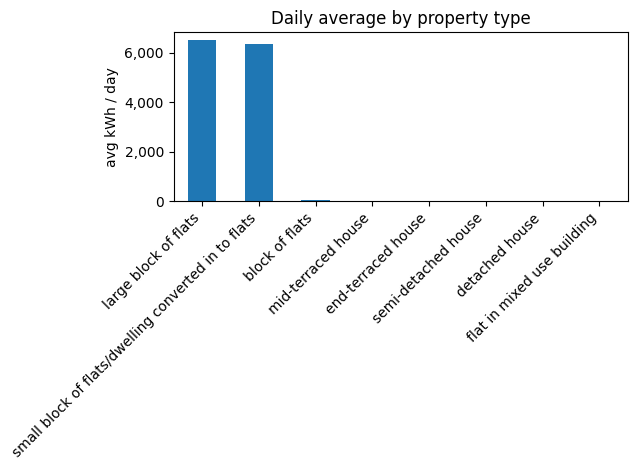

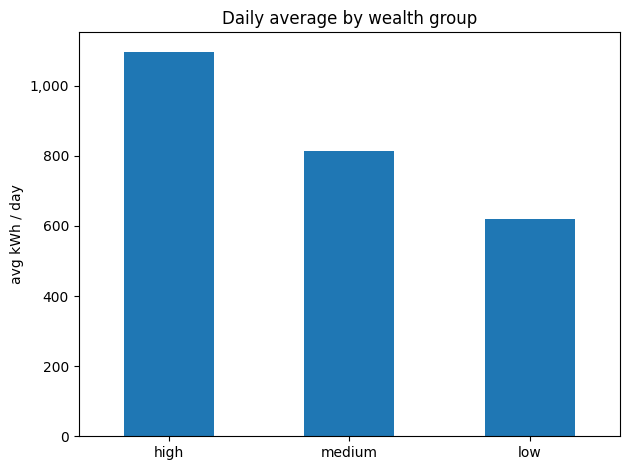

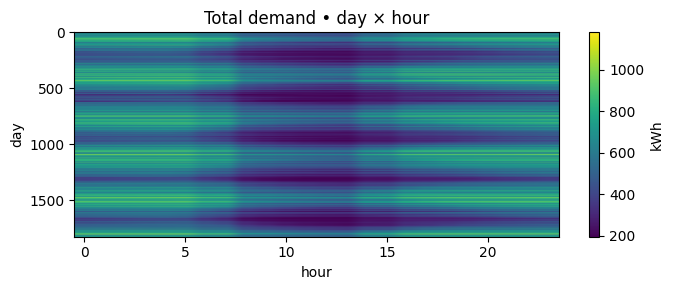

In [131]:
# ── Replicate analyze.py-style visuals from in-memory model ───────────────────
import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib.ticker as mtick

# 0) Pull the model timeseries like analyze.py expects (hourly UTC rows)
def ensure_model_df(m, start_utc_aligned=None):
    df = m.datacollector.get_model_vars_dataframe().copy()
    if not isinstance(df.index, pd.DatetimeIndex):
        if start_utc_aligned is None:
            start_utc_aligned = pd.to_datetime(getattr(m.climate, "times", [])[getattr(m, "_t0", 0)], utc=True)
        df["hour_start_utc"] = start_utc_aligned + pd.to_timedelta(df.index - 1, unit="h")
        df = df.set_index("hour_start_utc")
    if len(df) and df.index.is_monotonic_increasing:
        df = df.iloc[1:]
    return df

model_ts = ensure_model_df(m, start_utc_aligned=start_utc_aligned)
if 'end_utc_e' in globals() and end_utc_e is not None:
    model_ts = model_ts.loc[model_ts.index < end_utc_e]

# 1) Helpers copied from analyze.py
def find_wealth_cols(df: pd.DataFrame):
    return [c for c in ("high","medium","low") if c in df.columns]

def infer_property_energy_cols(model_ts: pd.DataFrame):
    """Heuristically pick columns that represent energy by property type at the model level.
       Rule: numeric columns excluding known metrics/wealth, whose row-wise sum ≈ total_energy."""
    known_metrics = {"total_energy", "cumulative_energy", "ambient_mean_tempC"}
    wealth = set(find_wealth_cols(model_ts))
    numeric_cols = [c for c in model_ts.columns if pd.api.types.is_numeric_dtype(model_ts[c])]
    candidates = [c for c in numeric_cols if c not in known_metrics | wealth]
    if "total_energy" not in model_ts.columns or not len(candidates):
        return []
    s = model_ts[candidates].sum(axis=1)
    te = model_ts["total_energy"]
    with np.errstate(invalid="ignore", divide="ignore"):
        ok = (np.isfinite(te) & (np.abs(s - te) <= np.maximum(1e-6, 1e-3*np.abs(te))))
    if ok.mean() >= 0.95:
        return candidates
    # fallback to common labels (rarely needed)
    common = [c for c in candidates if c.lower() in {
        "detached","detached house","semi-detached","semi_detached","semi-detached house",
        "terraced","mid-terraced house","end-terraced house",
        "flat","block of flats","large block of flats","small block of flats/dwelling converted in to flats",
        "flat in mixed use building"
    }]
    return common

# 2) Numeric casting + day/hour fields (analyze.py uses daily sums)
wealth_cols = find_wealth_cols(model_ts)
prop_cols   = infer_property_energy_cols(model_ts)

num_cols = wealth_cols + prop_cols + [c for c in ("total_energy",) if c in model_ts.columns]
for c in num_cols:
    model_ts[c] = pd.to_numeric(model_ts[c], errors="coerce")

if "day" not in model_ts.columns:
    model_ts["day"]  = np.arange(len(model_ts)) // 24
if "hour" not in model_ts.columns:
    model_ts["hour"] = model_ts.index.hour if isinstance(model_ts.index, pd.DatetimeIndex) else (np.arange(len(model_ts)) % 24)

# ── Plot 1 (by property type): average daily kWh ─────────────────────────────
if prop_cols:
    daily_type = model_ts.groupby("day")[prop_cols].sum()
    fig = plt.figure()
    (daily_type.mean().sort_values(ascending=False)).plot.bar()
    plt.ylabel("avg kWh / day")
    plt.title("Daily average by property type")
    plt.xticks(rotation=45, ha="right")
    plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x:,.0f}"))
    fig.tight_layout()
    plt.show()
else:
    print("ℹ️ No property-type energy columns found; skipping property-type plot.")

# ── Plot 2 (by wealth): average daily kWh ────────────────────────────────────
if wealth_cols:
    daily_w = model_ts.groupby("day")[wealth_cols].sum()
    avg_w   = daily_w.mean().loc[wealth_cols]  # keep order high, medium, low
    fig = plt.figure()
    ax = avg_w.plot.bar()
    ax.set_ylabel("avg kWh / day")
    ax.set_title("Daily average by wealth group")
    ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x:,.0f}"))
    plt.xticks(rotation=0)
    fig.tight_layout()
    plt.show()
else:
    print("ℹ️ No wealth columns – skipping wealth plot.")

# ── Plot 3 (temporal heatmap): day × hour of total demand ────────────────────
hourly = model_ts[["day","hour","total_energy"]].dropna()
if {"day","hour","total_energy"}.issubset(hourly.columns):
    pivot = hourly.pivot_table(index="day", columns="hour", values="total_energy", aggfunc="sum")
    fig = plt.figure(figsize=(7,3))
    plt.imshow(pivot.values, aspect="auto")
    plt.colorbar(label="kWh")
    plt.xlabel("hour"); plt.ylabel("day")
    plt.title("Total demand • day × hour")
    fig.tight_layout()
    plt.show()
else:
    print("⚠️ Missing expected columns; skipping day×hour plot.")


In [132]:
m.agent_dc.get_agent_vars_dataframe()

agent_type  energy  energy_consumption  ambient_tempC  \
Step  AgentID                                                                 
0     4510053284       household   0.000                 0.0            NaN   
      4510722762       household   0.000                 0.0            NaN   
      4510702147       household   0.000                 0.0            NaN   
      4510702145       household   0.000                 0.0            NaN   
      4510720917       household   0.000                 0.0            NaN   
...                          ...     ...                 ...            ...   
43848 4510720953_2189     person   0.048                 0.0            NaN   
      4510720919_2190     person   0.078                 0.0            NaN   
      4510720919_2191     person   0.060                 0.0            NaN   
      4510722807_2192     person   0.048                 0.0            NaN   
      4510722807_2193     person   0.048                 0.0            NaN   

                       climate_heating_kWh  climate_cooling_kWh  \
Step  AgentID                                                     
0     4510053284                       0.0                  0.0   
      4510722762                       0.0                  0.0   
      4510702147                       0.0                  0.0   
      4510702145                       0.0                  0.0   
      4510720917                       0.0                  0.0   
...                                    ...                  ...   
43848 4510720953_2189                  0.0                  0.0   
      4510720919_2190                  0.0                  0.0   
      4510720919_2191                  0.0                  0.0   
      4510722807_2192                  0.0                  0.0   
      4510722807_2193                  0.0                  0.0   

                                                           property_type  \
Step  AgentID                                                              
0     4510053284                                    large block of flats   
      4510722762       small block of flats/dwelling converted in to ...   
      4510702147                                    large block of flats   
      4510702145                                    large block of flats   
      4510720917       small block of flats/dwelling converted in to ...   
...                                                                  ...   
43848 4510720953_2189                                               None   
      4510720919_2190                                               None   
      4510720919_2191                                               None   
      4510722807_2192                                               None   
      4510722807_2193                                               None   

                       sap_rating  annual_energy_kwh  floor_area_m2  ...  \
Step  AgentID                                                        ...   
0     4510053284             75.0        3587.487947           48.0  ...   
      4510722762             76.0        4029.884398           68.0  ...   
      4510702147             77.0        4778.787606           60.0  ...   
      4510702145             77.0        5968.577380           59.0  ...   
      4510720917             81.0        1878.675033           63.0  ...   
...                           ...                ...            ...  ...   
43848 4510720953_2189         NaN                NaN            NaN  ...   
      4510720919_2190         NaN                NaN            NaN  ...   
      4510720919_2191         NaN                NaN            NaN  ...   
      4510722807_2192         NaN                NaN            NaN  ...   
      4510722807_2193         NaN                NaN            NaN  ...   

                      cwi_flag swi_flag loft_ins_flag  floor_ins_flag  \
Step  AgentID                                                          

In [133]:
# --- Top-consuming households per year ---------------------------------------
import pandas as pd, numpy as np
import geopandas as gpd

# 0) pull agent DF
adf = m.agent_dc.get_agent_vars_dataframe().reset_index()

# 1) households only
adf = adf[adf["agent_type"].astype(str).str.lower().eq("household")].copy()

# 2) add timestamp + year from Step
adf["Step"] = pd.to_numeric(adf["Step"], errors="coerce").astype("Int64")
adf = adf[adf["Step"].notna()]
adf["hour_start_utc"] = pd.to_datetime(start_utc_aligned) + pd.to_timedelta(adf["Step"] - 1, unit="h")
adf["year"] = adf["hour_start_utc"].dt.year

# 3) choose energy metric
energy_col = "annual_energy_kwh" if "annual_energy_kwh" in adf.columns else (
             "energy_consumption" if "energy_consumption" in adf.columns else "energy")
if energy_col not in adf.columns:
    raise ValueError("No energy column found in agent DF (looked for annual_energy_kwh, energy_consumption, energy).")

# 4) take the LAST record per (year, AgentID) as the annual snapshot
adf_sorted = adf.sort_values(["year", "AgentID", "Step"])
annual_last = adf_sorted.groupby(["year", "AgentID"], as_index=False).tail(1)

# 5) build tidy annual table (kWh) + carry useful metadata (last seen in that year)
meta_cols = [c for c in [
    "property_type","sap_rating","floor_area_m2","is_off_gas","is_electric_heating","is_gas","is_oil","is_solid_fuel",
    "UPRN","lsoa_code","ward_code"
] if c in annual_last.columns]

house_kwh = (
    annual_last[["year","AgentID", energy_col] + meta_cols]
      .rename(columns={energy_col: "annual_kwh"})
)

# If geometry is not in the collector, attach from the running model’s agents
if "geometry" not in annual_last.columns or annual_last["geometry"].isna().all():
    try:
        geoms = [h.geometry for h in m.household_agents]
        ids   = [getattr(h, "unique_id", i) for i, h in enumerate(m.household_agents)]
        g_lookup = pd.DataFrame({"AgentID": ids, "geometry": geoms})
        house_kwh = house_kwh.merge(g_lookup, on="AgentID", how="left")
    except Exception:
        pass
else:
    house_kwh["geometry"] = annual_last["geometry"]

# 6) function: top N per chosen year
def top_consumers(hk: pd.DataFrame, year: int, N: int = 50) -> pd.DataFrame:
    dfy = hk[hk["year"] == year].copy()
    dfy = dfy.sort_values("annual_kwh", ascending=False).head(N)
    # nice display types
    for c in ("sap_rating","floor_area_m2"):
        if c in dfy.columns: dfy[c] = pd.to_numeric(dfy[c], errors="coerce")
    return dfy.reset_index(drop=True)

# === Use it ===
YEAR = 2022  # <-- change year here
TOPN = 500

topN = top_consumers(house_kwh, YEAR, TOPN).copy()

# Enrich topN with UPRN / lsoa_code / geometry (prefer ID-join, fallback to nearest join)

# --- 1) Try fast, lossless ID-join (AgentID == UPRN in this model) ---
if "UPRN" in gdf_lsoa.columns:
    lookup = gdf_lsoa[["UPRN","lsoa_code","geometry"]].copy()
    lookup["UPRN"] = lookup["UPRN"].astype(str)
    topN["AgentID"] = topN["AgentID"].astype(str)

    topN = topN.merge(lookup, left_on="AgentID", right_on="UPRN", how="left")
else:
    print("⚠️ gdf_lsoa has no UPRN column; skipping ID-join.")

# --- 2) Fallback: nearest spatial join ONLY for rows still missing geometry ---
need_geo = "geometry" not in topN.columns or topN["geometry"].isna().any()
if need_geo:
    try:
        import geopandas as gpd
        # Build GeoDF from model agents (guaranteed to exist)
        geoms = [h.geometry for h in m.household_agents]
        ids   = [getattr(h, "unique_id", i) for i, h in enumerate(m.household_agents)]
        g_agents = gpd.GeoDataFrame({"AgentID": ids, "geometry": geoms}, crs=gdf_lsoa.crs or 27700)
        g_agents["AgentID"] = g_agents["AgentID"].astype(str)

        # Left-join by AgentID to get geometry; no CRS warnings, no length mismatch
        topN = topN.merge(g_agents, on="AgentID", how="left", suffixes=("", "_from_agents"))

        # If lsoa_code still missing, do a PROPER projected nearest-join (27700) just for that col
        if "lsoa_code" not in topN.columns or topN["lsoa_code"].isna().any():
            # ensure projected CRS for nearest
            gsrc = gdf_lsoa[["lsoa_code","geometry"]].copy()
            if gsrc.crs is None:
                gsrc.set_crs(27700, inplace=True)  # best guess for UK data
            if topN.geometry.crs != gsrc.crs:
                topN = gpd.GeoDataFrame(topN, geometry="geometry").to_crs(gsrc.crs)
            # run nearest on the subset that still needs lsoa_code
            miss_idx = topN.index[topN["lsoa_code"].isna()] if "lsoa_code" in topN.columns else topN.index
            if len(miss_idx) > 0:
                joined = gpd.sjoin_nearest(topN.loc[miss_idx, ["geometry"]], gsrc, how="left", distance_col="dist_m")
                topN.loc[miss_idx, "lsoa_code"] = joined["lsoa_code"].values
    except Exception as e:
        print(f"(Spatial enrichment skipped: {e})")


# Display only columns that exist
preferred_cols = ["AgentID","annual_kwh","UPRN","property_type","sap_rating","floor_area_m2","lsoa_code"]
show_cols = [c for c in preferred_cols if c in topN.columns]
display(topN[show_cols])

print(f"Listed top {len(topN)} households by annual energy in {YEAR}.")

# --- Quick map of top N -----------------
try:
    import folium, branca.colormap as cm, numpy as np, html
    from pathlib import Path
    import geopandas as gpd

    if "geometry" in topN.columns and topN["geometry"].notna().any():
        gtop = gpd.GeoDataFrame(
            topN.dropna(subset=["geometry"]).copy(),
            geometry="geometry",
            crs=(gdf_lsoa.crs or 27700)
        )
        gtop_wgs = gtop.to_crs(4326)

        # Color scale from robust percentiles
        vals = pd.to_numeric(gtop_wgs["annual_kwh"], errors="coerce")
        vmin, vmax = np.nanpercentile(vals[np.isfinite(vals)], [5, 95]) if np.isfinite(vals).any() else (0.0, 1.0)
        cmap = cm.linear.YlOrRd_09.scale(vmin, vmax).to_step(10)
        cmap.caption = f"Annual kWh (top {len(gtop_wgs)})"

        # Helper to format tooltip safely
        def fmt_tooltip(row):
            parts = [f"<b>{int(row['annual_kwh']):,} kWh</b>"]
            if "UPRN" in row and pd.notna(row["UPRN"]):
                parts.append(f"UPRN: {html.escape(str(row['UPRN']))}")
            if "property_type" in row and pd.notna(row["property_type"]):
                parts.append(html.escape(str(row["property_type"])))
            if "sap_rating" in row and pd.notna(row["sap_rating"]):
                parts.append(f"SAP: {float(row['sap_rating']):.0f}")
            if "floor_area_m2" in row and pd.notna(row["floor_area_m2"]):
                parts.append(f"Floor: {float(row['floor_area_m2']):.1f} m²")
            if "lsoa_code" in row and pd.notna(row["lsoa_code"]):
                parts.append(f"LSOA: {html.escape(str(row['lsoa_code']))}")

            # Fuel / off-gas summary if flags exist
            fuels = []
            for lab, col in [("elec","is_electric_heating"),
                             ("gas","is_gas"),
                             ("oil","is_oil"),
                             ("solid","is_solid_fuel")]:
                if col in row and pd.notna(row[col]) and float(row[col]) == 1.0:
                    fuels.append(lab)
            if "is_off_gas" in row and pd.notna(row["is_off_gas"]):
                parts.append(("off-gas" if int(row["is_off_gas"]) == 1 else "on-gas")
                             + (f" • fuel: {', '.join(fuels)}" if fuels else ""))

            return "<br>".join(parts)

        center = [gtop_wgs.geometry.y.mean(), gtop_wgs.geometry.x.mean()]
        fmap = folium.Map(location=center, zoom_start=12, tiles="cartodbpositron")

        for _, r in gtop_wgs.iterrows():
            kwh = float(r["annual_kwh"])
            color = cmap(kwh) if np.isfinite(kwh) else "#777"
            tooltip = fmt_tooltip(r)
            folium.CircleMarker(
                location=[r.geometry.y, r.geometry.x],
                radius=4, color="#222", weight=0.6,
                fill=True, fill_color=color, fill_opacity=0.9,
                tooltip=tooltip
            ).add_to(fmap)

        cmap.add_to(fmap)
        out = Path(f"top{TOPN}_households_{YEAR}.html")
        fmap.save(out)
        print(f"🗺️ Saved map: {out.resolve()}")
    else:
        print("ℹ️ No geometries available for the top-N; skipping map.")
except Exception as e:
    print(f"(Map skipped: {e})")




AgentID    annual_kwh        UPRN  \
0    4510120154  14405.817552  4510120154   
1    4510722766  12040.581917  4510722766   
2    4510133481   8391.452894  4510133481   
3    4510720847   8378.354637  4510720847   
4    4510702150   8370.805210  4510702150   
..          ...           ...         ...   
495  4510726382   1985.310696  4510726382   
496  4510721960   1981.347247  4510721960   
497  4510720480   1980.969775  4510720480   
498  4510738674   1976.440119  4510738674   
499  4510725688   1975.118969  4510725688   

                                         property_type  sap_rating  \
0                                 large block of flats        12.0   
1    small block of flats/dwelling converted in to ...        62.0   
2    small block of flats/dwelling converted in to ...        31.0   
3                                 large block of flats        48.0   
4                                       block of flats        64.0   
..                                                 ...         ...   
495  small block of flats/dwelling converted in to ...        80.0   
496  small block of flats/dwelling converted in to ...        73.0   
497                               large block of flats        75.0   
498                               large block of flats        62.0   
499                               large block of flats        75.0   

     floor_area_m2  lsoa_code  
0            58.00  E01033545  
1           389.00  E01033545  
2            51.46  E01033545  
3           124.00  E01033545  
4           132.00  E01033545  
..             ...        ...  
495          67.00  E01033545  
496          58.00  E01033545  
497          64.00  E01033545  
498          28.00  E01033545  
499          65.00  E01033545  

[500 rows x 7 columns]

Listed top 500 households by annual energy in 2022.
🗺️ Saved map: /Users/abeltran/Documents/GitHub/spdt_abm/notebooks/top500_households_2022.html


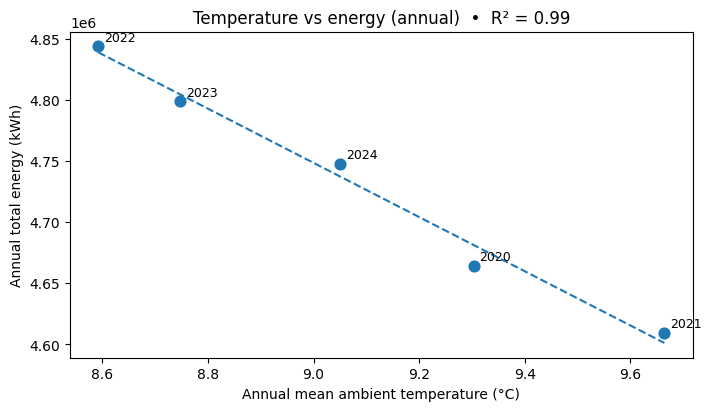

In [134]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt

def get_annual_from_model(df: pd.DataFrame) -> pd.DataFrame:
    # tolerate both column names for temperature
    temp_col = "ambient_mean_tempC" if "ambient_mean_tempC" in df.columns else (
               "ambient_mean_tempC_avg" if "ambient_mean_tempC_avg" in df.columns else None)
    out = pd.DataFrame({
        "total_energy_kWh": df["total_energy"].resample("YE").sum()
    })
    if temp_col:
        out["mean_tempC"] = df[temp_col].resample("YE").mean()
    out.index = out.index.year
    return out

# (re)build annual_df no matter what 'annual' was
annual_df = get_annual_from_model(model_df)

if "mean_tempC" in annual_df.columns and annual_df["mean_tempC"].notna().any():
    x = annual_df["mean_tempC"].astype(float).values
    y = annual_df["total_energy_kWh"].astype(float).values

    a, b = np.polyfit(x, y, 1)
    yhat = a * x + b
    r2 = 1 - np.sum((y - yhat)**2) / np.sum((y - y.mean())**2)

    fig, ax = plt.subplots(figsize=(7, 4), constrained_layout=True)
    ax.scatter(x, y, s=60)
    xs = np.linspace(float(np.min(x)), float(np.max(x)), 100)
    ax.plot(xs, a*xs + b, linestyle="--")
    for yr, xi, yi in zip(annual_df.index, x, y):
        ax.annotate(str(int(yr)), (xi, yi), xytext=(4, 4), textcoords="offset points", fontsize=9)
    ax.set_xlabel("Annual mean ambient temperature (°C)")
    ax.set_ylabel("Annual total energy (kWh)")
    ax.set_title(f"Temperature vs energy (annual)  •  R² = {r2:.2f}")
    plt.show()
else:
    print("ℹ️ No ambient temperature column in model_df; skipping temp–energy scatter.")


## Validation against DESNZ (LSOA)
<span id="doc-desnz"></span>

Use the notebook’s tidy loader to normalize DESNZ LSOA sheets and combine **electricity + gas** by **LSOA × year**. Compare **ABM annual totals** (`model_df.resample("YS")`) to DESNZ **Elec+Gas** totals for **2020–2023**, scoped to the **same LSOA** you simulated. For per‑dwelling comparisons, divide totals by the number of dwellings in the subset (or by type‑specific counts).


In [ ]:
# === Read DESNZ (LSOA Elec+Gas) → combine → compare to ABM for the current LSOA (2020–2023) ===
from pathlib import Path
import pandas as pd, numpy as np, re, matplotlib.pyplot as plt

# ---- Paths & config (edit if needed) ----
ELEC_XLSX = "../data/LSOA_domestic_elec_2010-2023.xlsx"
GAS_XLSX  = "../data/LSOA_domestic_gas_2010-2023.xlsx"
LA_FILTER = "newcastle upon tyne"
YEARS = [2020, 2021, 2022, 2023]

# ---- Column normalization for DESNZ sheets ----
NORM_COLMAP = {
    "Local authority code": "la_code",
    "Local authority": "local_authority",
    "MSOA code": "msoa_code",
    "Middle layer super output area": "msoa_name",
    "LSOA code": "lsoa_code",
    "Lower layer super output area": "lsoa_name",
    "Number of meters": "meters",
    "Total consumption (kWh)": "total_kwh",
    "Mean consumption (kWh per meter)": "mean_kwh",
    "Median consumption (kWh per meter)": "median_kwh",
}

def tidy_lsoa(xlsx_path: str | Path, fuel: str, la_filter: str) -> pd.DataFrame:
    # Read all sheets; DESNZ header is on row 5 (0-indexed 4)
    book = pd.read_excel(xlsx_path, sheet_name=None, header=4, engine="openpyxl")
    # Drop the first sheet (typically notes/contents)
    first = next(iter(book))
    book.pop(first, None)

    frames = []
    for sheet_name, df in book.items():
        # Normalise headers
        df = df.copy()
        df.columns = df.columns.astype(str).str.replace(r"\s+", " ", regex=True).str.strip()
        df = df.rename(columns={k: v for k, v in NORM_COLMAP.items() if k in df.columns})

        # Keep only available expected columns
        wanted = ["la_code","local_authority","msoa_code","msoa_name",
                  "lsoa_code","lsoa_name","meters","total_kwh","mean_kwh","median_kwh"]
        keep = [c for c in wanted if c in df.columns]
        if not keep:
            continue
        df = df[keep].copy()

        # Numeric coercion (strip thousands separators)
        for c in {"meters","total_kwh","mean_kwh","median_kwh"} & set(keep):
            df[c] = pd.to_numeric(df[c].astype(str).str.replace(",", "", regex=False), errors="coerce")

        # Year from sheet name
        m = re.search(r"(20\d{2})", str(sheet_name))
        if not m:
            continue
        df["year"] = int(m.group(1))
        df["fuel"] = fuel

        # Filter: drop unallocated & keep LA
        if "lsoa_code" in df.columns:
            df = df[~df["lsoa_code"].astype(str).str.contains("unallocated", case=False, na=False)]
        if "local_authority" in df.columns:
            df["local_authority"] = df["local_authority"].astype(str).str.strip()
            #df = df[df["local_authority"].str.contains(la_filter, case=False, na=False)]

        frames.append(df)

    if not frames:
        return pd.DataFrame(columns=["year","fuel","lsoa_code","lsoa_name","total_kwh","meters","local_authority"])
    out = pd.concat(frames, ignore_index=True)
    ordered = [c for c in ["year","fuel","la_code","local_authority","msoa_code","msoa_name",
                           "lsoa_code","lsoa_name","meters","total_kwh","mean_kwh","median_kwh"]
               if c in out.columns]
    return out[ordered].sort_values(["year","lsoa_code"]).reset_index(drop=True)


In [ ]:

# ---- Load DESNZ (electricity + gas) ----
elec = tidy_lsoa(ELEC_XLSX, "electricity", LA_FILTER)
gas  = tidy_lsoa(GAS_XLSX,  "gas",        LA_FILTER)


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x105f71eb0>>
Traceback (most recent call last):
  File "/Users/abeltran/Documents/GitHub/spdt_abm/esa_mesa/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 781, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


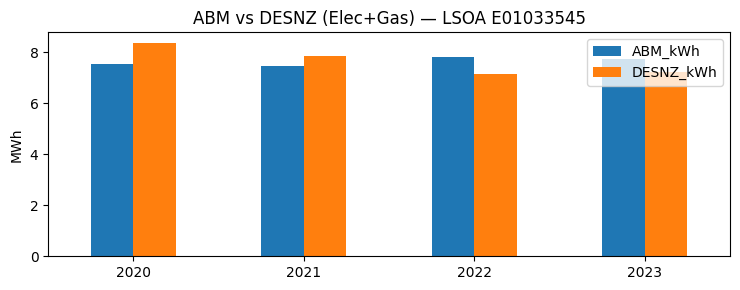

In [ ]:

# ---- Determine target LSOA (from your subset) ----
src = gdf_lsoa if 'gdf_lsoa' in globals() else gdf
lsoa_col = next((c for c in src.columns if re.search(r"lsoa.*(code|cd)", c, re.I)), None)
assert lsoa_col, "Could not find an LSOA code column on your GeoDataFrame."
lsoa_code = src[lsoa_col].astype(str).dropna().unique()
assert len(lsoa_code) == 1, f"Expected exactly 1 LSOA in the subset; found {len(lsoa_code)}."
lsoa_code = lsoa_code[0]

# ---- DESNZ per-year Elec+Gas totals for this LSOA ----
desnz_long = pd.concat([elec, gas], ignore_index=True)
desnz_year = (desnz_long[desnz_long["lsoa_code"].astype(str) == lsoa_code]
              .groupby("year")["total_kwh"].sum()
              .reindex(YEARS))
desnz_year.name = "DESNZ_kWh"

# ---- ABM annual totals from your in-memory model_df ----
def _ensure_model_df(mdf=None):
    if mdf is not None:
        return mdf
    # Fallback if model_df not defined: rebuild from `m`, `start_utc_aligned`, `end_utc_e`
    assert 'm' in globals() and 'start_utc_aligned' in globals() and 'end_utc_e' in globals(), \
        "Provide model_df or define m/start_utc_aligned/end_utc_e."
    df = m.datacollector.get_model_vars_dataframe().copy()
    df["hour_start_utc"] = pd.to_datetime(start_utc_aligned, utc=True) + pd.to_timedelta(df.index - 1, unit="h")
    df = df.set_index("hour_start_utc").iloc[1:]
    return df.loc[(df.index >= pd.to_datetime(start_utc_aligned, utc=True)) &
                  (df.index <  pd.to_datetime(end_utc_e,    utc=True))]

model_df = _ensure_model_df(model_df if 'model_df' in globals() else None)
abm_year = (model_df["total_energy"].resample("YS").sum())
abm_year.index = abm_year.index.year
abm_year = abm_year.reindex(YEARS)
abm_year.name = "ABM_kWh"

# ---- Compare + plot ----
cmp = pd.concat([abm_year, desnz_year], axis=1)
cmp["ABM/DESNZ"] = cmp["ABM_kWh"] / cmp["DESNZ_kWh"]

display(cmp.style.format({"ABM_kWh":"{:,.0f}","DESNZ_kWh":"{:,.0f}","ABM/DESNZ":"{:.3f}"}).set_caption(f"LSOA {lsoa_code}"))

(cmp[["ABM_kWh","DESNZ_kWh"]]/1e6).plot(kind="bar", figsize=(7.5,3))
plt.ylabel("MWh")
plt.title(f"ABM vs DESNZ (Elec+Gas) — LSOA {lsoa_code}")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
desnz_per_dw

year
2020    7518.114748
2021    6998.351980
2022    6403.120055
2023    6426.290626
Name: DESNZ_kWh_per_dwelling, dtype: float64

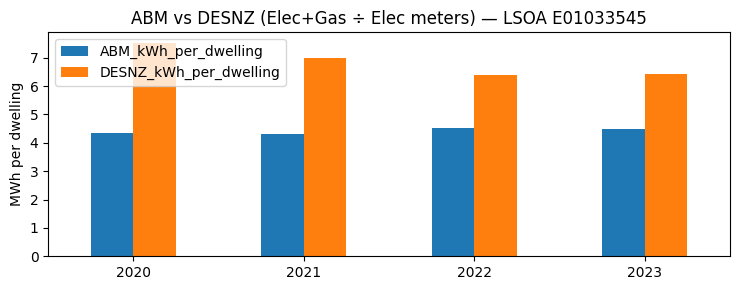

In [ ]:
# ---- DESNZ: (elec + gas) total, divided by ELEC meters only -----------------
# numerator: sum of total_kwh across elec+gas
desnz_total = (
    pd.concat([elec, gas], ignore_index=True)
      .loc[lambda d: d["lsoa_code"].astype(str) == lsoa_code]
      .groupby("year")["total_kwh"].sum()
      .reindex(YEARS)
)

# denominator: electricity meters only
elec_meters = (
    elec[elec["lsoa_code"].astype(str) == lsoa_code]
        .groupby("year")["meters"].sum()
        .reindex(YEARS)
)

desnz_per_dw = (desnz_total / elec_meters.replace(0, np.nan)).fillna(np.nan)
desnz_per_dw.name = "DESNZ_kWh_per_dwelling"

# ---- ABM: total energy divided by number of UPRNs in your subset -----------
n_uprn = len(src)
abm_per_dw = (model_df["total_energy"].resample("YS").sum() / n_uprn)
abm_per_dw.index = abm_per_dw.index.year
abm_per_dw = abm_per_dw.reindex(YEARS)
abm_per_dw.name = "ABM_kWh_per_dwelling"

# ---- Compare + plot ---------------------------------------------------------
cmp = pd.concat([abm_per_dw, desnz_per_dw], axis=1)
cmp["ABM/DESNZ"] = cmp["ABM_kWh_per_dwelling"] / cmp["DESNZ_kWh_per_dwelling"]

display(
    cmp.style.format({
        "ABM_kWh_per_dwelling": "{:,.0f}",
        "DESNZ_kWh_per_dwelling": "{:,.0f}",
        "ABM/DESNZ": "{:.3f}",
    }).set_caption(f"LSOA {lsoa_code} • ABM vs DESNZ (per dwelling, denom = elec meters)")
)

(cmp[["ABM_kWh_per_dwelling","DESNZ_kWh_per_dwelling"]] / 1e3).plot(kind="bar", figsize=(7.5,3))
plt.ylabel("MWh per dwelling")
plt.title(f"ABM vs DESNZ (Elec+Gas ÷ Elec meters) — LSOA {lsoa_code}")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
n_uprn# 0) ensure unique UPRNs in your EPC subset
n_uprn_raw = len(src)
n_uprn = src["UPRN"].astype(str).nunique() if "UPRN" in src.columns else np.nan

# 1) electricity meters by year
elec_m_by_year = (
    elec[elec["lsoa_code"].astype(str) == lsoa_code]
      .groupby("year")["meters"].sum()
      .reindex(YEARS)
)

print({
    "UPRNs_raw_rows": n_uprn_raw,
    "UPRNs_unique": n_uprn,
    "elec_meters_by_year": elec_m_by_year.to_dict(),
    "UPRN_over_meters_2020": (n_uprn / elec_m_by_year.loc[2020]) if elec_m_by_year.loc[2020] else None,
    "UPRN_over_meters_2023": (n_uprn / elec_m_by_year.loc[2023]) if elec_m_by_year.loc[2023] else None,
})


{'UPRNs_raw_rows': 1729, 'UPRNs_unique': 1097, 'elec_meters_by_year': {2020: 1112.0, 2021: 1119.0, 2022: 1117.0, 2023: 1122.0}, 'UPRN_over_meters_2020': np.float64(0.9865107913669064), 'UPRN_over_meters_2023': np.float64(0.9777183600713012)}
